In [0]:
import torch
from torch.utils.data.dataloader import DataLoader
import minGPT
from minGPT.mingpt.utils import set_seed

set_seed(3407)
print(torch.cuda.device_count())
from torch.nn import functional as F

import InContextLearningExperiments.icldatasets_new_idea as datasets

1


In [0]:
import importlib
importlib.reload(datasets)
importlib.reload(minGPT)

<module 'minGPT' (namespace) from ['/Workspace/Users/naman.agarwal@dreamsports.group/minGPT', '/Workspace/Users/naman.agarwal@dreamsports.group/minGPT']>

In [0]:
import seaborn as sns

import matplotlib.pyplot as plt

In [0]:
# Set context length (2*length+1) and vocab_size
train_dataset_mixed_dict = {}
mixed_loaders = {}
l = 50
length = l
vocab_size = l
# train_dataset_changing_dict[l] = datasets.KVRetrievalDatasetChangingDictNewIdea('train', vocab_size=vocab_size, length=length, perm_or_random='perm')
# changing_loader[l] = DataLoader(train_dataset_changing_dict, batch_size=1, num_workers=0, drop_last=False)
train_dataset_mixed_dict[l] = datasets.KVRetrievalDatasetMixedDictNewIdea('train', vocab_size=vocab_size, length=length, mixing_fraction=0.0, perm_or_random='perm')
mixed_loaders[l] = DataLoader(train_dataset_mixed_dict[l], batch_size=32, num_workers=0, drop_last=False)




In [0]:
# create a GPT instance
from minGPT.mingpt.model import GPT
# create a Trainer object
from minGPT.mingpt.trainer import Trainer


losses = []
def batch_end_callback(trainer):
    losses.append(trainer.loss.item())
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}; mean loss last 20 iters: {np.mean(losses[-20:]):.5f}")

In [0]:
depths = [6]
n_embd = 192
heads = [6]
model_dicts = {}
trainer_dicts = {}
for d in depths:
  for h in heads:
    length = l
    vocab_size = l
    model_config = GPT.get_default_config()
    model_config.model_type = None
    model_config.vocab_size = 2*vocab_size
    model_config.block_size = 2*length - 1
    model_config.n_layer = d
    model_config.n_head = h
    model_config.n_embd = n_embd

    train_config = Trainer.get_default_config()
    train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
    train_config.max_iters = 20000
    train_config.num_workers = 0
    model_dicts[(d, h)] = GPT(model_config)
    trainer_dicts[(d, h)] = Trainer(train_config, model_dicts[(d, h)], train_dataset_mixed_dict[l])
    trainer_dicts[(d, h)].set_callback('on_batch_end', batch_end_callback)
    trainer_dicts[(d, h)].run()


number of parameters: 2.71M
running on device cuda
Print to test changes are going though
iter_dt 0.00ms; iter 0: train loss 4.63869
iter_dt 113.40ms; iter 100: train loss 4.03327
iter_dt 112.95ms; iter 200: train loss 3.94034
iter_dt 114.30ms; iter 300: train loss 3.90785
iter_dt 107.51ms; iter 400: train loss 3.86688
iter_dt 110.01ms; iter 500: train loss 3.81143
iter_dt 109.53ms; iter 600: train loss 3.76376
iter_dt 107.81ms; iter 700: train loss 3.72659
iter_dt 124.23ms; iter 800: train loss 3.69146
iter_dt 107.28ms; iter 900: train loss 3.66188
iter_dt 104.64ms; iter 1000: train loss 3.62530
iter_dt 111.17ms; iter 1100: train loss 3.60435
iter_dt 90.90ms; iter 1200: train loss 3.57651
iter_dt 117.54ms; iter 1300: train loss 3.56285
iter_dt 103.02ms; iter 1400: train loss 3.53496
iter_dt 98.95ms; iter 1500: train loss 3.51281
iter_dt 87.78ms; iter 1600: train loss 3.49427
iter_dt 98.68ms; iter 1700: train loss 3.47857
iter_dt 95.64ms; iter 1800: train loss 3.46298
iter_dt 93.63ms; 

In [0]:
import math
from scipy.stats import entropy
import numpy as np

In [0]:
import itertools

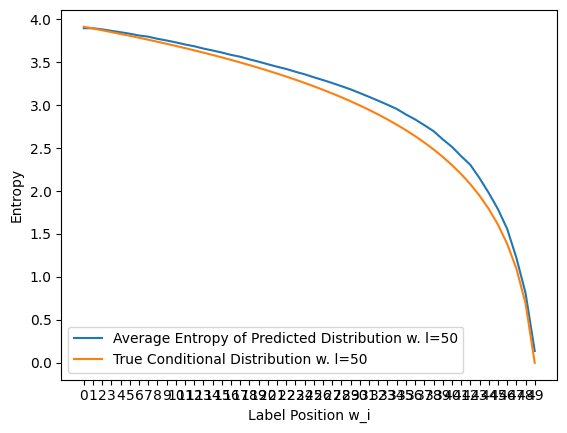

In [0]:
for (k,(d, n_embd)) in enumerate(list(itertools.product(depths, heads))):
  model_dict = model_dicts[(d, n_embd)]
  trainer_dict = trainer_dicts[(d, n_embd)]
  loader = mixed_loaders[l]
  #print(loader.dataset.dictionary)
  train_dataset_changing_dict = datasets.KVRetrievalDatasetChangingDictNewIdea('train', vocab_size=l, length=l, perm_or_random='perm')
  changing_loader = DataLoader(train_dataset_changing_dict, batch_size=1, num_workers=0, drop_last=False)

  samples = []
  j = 0
  while j < 100:
    a,b = next(iter(changing_loader))
    #print(a,b)
    if loader.dataset.dictionary[a[0][0]] != b[0][0]:
      j+=1
      samples.append([a,b])

  all_ents = []
  for a,b in samples:
    ans=model_dict.generate(a.to(trainer_dict.device), 1, do_sample=False)
    probs = F.softmax(ans[1], dim=-1)
    dict_so_far = {}
    things_fixed = 0
    entropies = []
    for i in range(0, ans[1].size(1), 2):
      entropies.append(entropy(probs[0][i].cpu().numpy()))
    all_ents.append(entropies)
  all_ents = np.array(all_ents)
  #print(all_ents)

  true_entropies = []
  for i in range(0, ans[1].size(1), 2):
    # if i==0:
    #   q = a[0][i].cpu().item()
    #   qa = b[0][i].cpu().item()
    #   j = i // 2
    #   pa = (0.9 + 0.1*math.factorial(l - (j+1))/math.factorial(l)) / (0.9 + 0.1*math.factorial(l - (j))/math.factorial(l))
    #   pb = (1 - pa)/(l-1)
    #   #print(pa)
    #   true_entropies.append(entropy([pa] + [pb]*(l-1)))
    # else:
    true_entropies.append(np.log(l - i//2))
    
  #print(entropies)
  stds = np.std(all_ents, axis=0)
  #print(stds)
  all_ents = np.mean(all_ents, axis=0)
  # if k == 0:
  #   plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1, label='±1 Std Dev Entropy of Predicted Distribution')
  # else:
  #   plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1)

  plt.plot(all_ents, label=f'Average Entropy of Predicted Distribution w. l={l}')

  plt.plot(true_entropies, label=f'True Conditional Distribution w. l={l}')
  plt.xlabel('Label Position w_i')
  plt.xticks(range(len(all_ents)))
  plt.ylabel('Entropy')
  plt.legend()
  plt.show()

[0.12227859 0.02577648 0.02014509 0.02502266 0.03464423 0.0424665
 0.05246561 0.09523968 0.1009225  0.04996781]


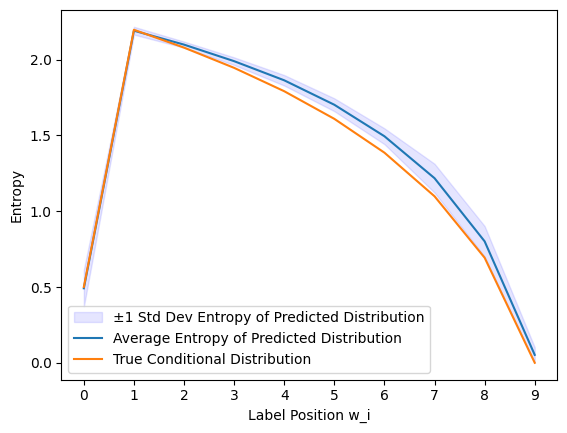

In [0]:
#train_dataset_fixed_dict = datasets.KVRetrievalDatasetFixedDictNewIdea('train', vocab_size=vocab_size, length=length, mixing_fraction=0.9, perm_or_random='perm', dictionary=loader.dataset.dictionary)
#fixed_loader = DataLoader(train_dataset_fixed_dict, batch_size=1, num_workers=0, drop_last=False)

samples = []
j = 0
while j < 100:
  a,b = next(iter(loader))
  if loader.dataset.dictionary[a[0][0]] != b[0][0]:
    j+=1
    samples.append([a,b])
  

all_ents = []
for a,b in samples:
  ans=model_dict.generate(a.to(trainer_dict.device), 1, do_sample=False)
  probs = F.softmax(ans[1], dim=-1)
  dict_so_far = {}
  things_fixed = 0
  entropies = []
  for i in range(0, ans[1].size(1), 2):
    entropies.append(entropy(probs[0][i].cpu().numpy()))
  all_ents.append(entropies)
all_ents = np.array(all_ents)
#print(all_ents)

true_entropies = []
for i in range(0, ans[1].size(1), 2):
  if i==0:
    q = a[0][i].cpu().item()
    qa = b[0][i].cpu().item()
    j = i // 2
    pa = (0.9 + 0.1*math.factorial(10 - (j+1))/math.factorial(10)) / (0.9 + 0.1*math.factorial(10 - (j))/math.factorial(10))
    pb = (1 - pa)/9 
    #print(pa)
    true_entropies.append(entropy([pa] + [pb]*9))
  else:
    true_entropies.append(np.log(10 - i//2))
  # if q in dict_so_far:
  #   true_entropies.append(np.log(1))
  # else:
  #   true_entropies.append(np.log(vocab_size - things_fixed))
  #   dict_so_far[q] = qa
  #   things_fixed += 1
  
#print(entropies)
stds = np.std(all_ents, axis=0)
print(stds)
all_ents = np.mean(all_ents, axis=0)
plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1, label='±1 Std Dev Entropy of Predicted Distribution')

plt.plot(all_ents, label='Average Entropy of Predicted Distribution')
plt.plot(true_entropies, label='True Conditional Distribution')
plt.xlabel('Label Position w_i')
plt.xticks(range(len(all_ents)))
plt.ylabel('Entropy')
plt.legend()
plt.show()

[0.15652254 0.05464776 0.02897016 0.03334576 0.04441554 0.05304552
 0.05564843 0.08320993 0.1080453  0.05775912]


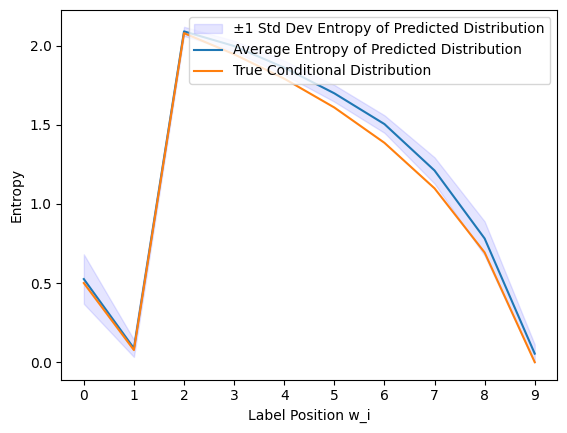

In [0]:
samples = []
j = 0
while j < 100:
  a,b = next(iter(loader))
  if (loader.dataset.dictionary[a[0][0]] == b[0][0]) and (loader.dataset.dictionary[a[0][2]] != b[0][2]):
    j+=1
    samples.append([a,b])
  

all_ents = []
for a,b in samples:
  ans=model_dict.generate(a.to(trainer_dict.device), 1, do_sample=False)
  probs = F.softmax(ans[1], dim=-1)
  dict_so_far = {}
  things_fixed = 0
  entropies = []
  for i in range(0, ans[1].size(1), 2):
    entropies.append(entropy(probs[0][i].cpu().numpy()))
  all_ents.append(entropies)
all_ents = np.array(all_ents)
#print(all_ents)

true_entropies = []
for i in range(0, ans[1].size(1), 2):
  if i < 3:
    q = a[0][i].cpu().item()
    qa = b[0][i].cpu().item()
    j = i // 2
    pa = (0.9 + 0.1*math.factorial(10 - (j+1))/math.factorial(10)) / (0.9 + 0.1*math.factorial(10 - (j))/math.factorial(10))
    pb = (1 - pa)/9 
    #print(pa)
    true_entropies.append(entropy([pa] + [pb]*9))
  else:
    true_entropies.append(np.log(10 - i//2))
  # if q in dict_so_far:
  #   true_entropies.append(np.log(1))
  # else:
  #   true_entropies.append(np.log(vocab_size - things_fixed))
  #   dict_so_far[q] = qa
  #   things_fixed += 1
  
#print(entropies)
stds = np.std(all_ents, axis=0)
print(stds)
all_ents = np.mean(all_ents, axis=0)
plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1, label='±1 Std Dev Entropy of Predicted Distribution')

plt.plot(all_ents, label='Average Entropy of Predicted Distribution')
plt.plot(true_entropies, label='True Conditional Distribution')
plt.xlabel('Label Position w_i')
plt.xticks(range(len(all_ents)))
plt.ylabel('Entropy')
plt.legend(loc='upper right')
plt.show()

In [0]:

# running a non cl trained trainer through non_cl dataset
with torch.no_grad():
    train_score_fixed_dict = eval_split(trainer_fixed_dict, model_fixed_dict, train_dataset_fixed_dict, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_mixed_dict_x1, max_batches=50, split='test')

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1051097308038049>, line 3
      1 # running a non cl trained trainer through non_cl dataset
      2 with torch.no_grad():
----> 3     train_score_fixed_dict = eval_split(trainer_fixed_dict, model_fixed_dict, train_dataset_fixed_dict, max_batches=50, split='train')
      4     test_score_fixed_dict  = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_fixed_dict, max_batches=50, split='test')
      5     test_score_changing_dict = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_changing_dict, max_batches=50, split='test')

NameError: name 'eval_split' is not defined

In [0]:
loader = DataLoader(test_dataset_fixed_dict, batch_size=1, num_workers=0, drop_last=False)
a = next(iter(loader))
a = [a[0].to(trainer_fixed_dict.device), a[1].to(trainer_fixed_dict.device)]

In [0]:

print(a)
with torch.no_grad():
  cat, att_matrices = model_fixed_dict.generate(a[0], 1, do_sample=False)
  print(cat)
  print(att_matrices)

In [0]:
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import pandas as pd

In [0]:
print(type(att_matrices[0][0]))
print(att_matrices[0][0].size())
for i in range(att_matrices[0][0].size()[1]):
  #plt.imshow(att_matrices[0][0][0][i].cpu(), cmap='hot', interpolation='nearest')
  ax = sns.heatmap(att_matrices[0][0][0][i].cpu(), linewidth=0.5, norm=LogNorm())
  plt.show()

In [0]:
def prettyprint(A):
  A = np.array(A)
  A = pd.DataFrame(A)
  A.columns = ['']*A.shape[1]
  print(A.to_string(index=False))

In [0]:
prettyprint(att_matrices[0][0][0][0].cpu())

In [0]:
model_changing_dict = GPT(model_config)
train_config.max_iters = 10000
trainer_changing_dict = Trainer(train_config, model_changing_dict, train_dataset_changing_dict)
trainer_changing_dict.set_callback('on_batch_end', batch_end_callback)
trainer_changing_dict.run()

In [0]:
# running a non cl trained trainer through non_cl dataset
with torch.no_grad():
    train_score_changing_dict = eval_split(trainer_changing_dict, model_changing_dict, train_dataset_changing_dict, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_mixed_dict_x1, max_batches=50, split='test')

In [0]:
model_mixed_dict_x1 = GPT(model_config)
train_config.max_iters = 10000
trainer_mixed_dict_x1 = Trainer(train_config, model_mixed_dict_x1, train_dataset_mixed_dict_x1)
trainer_mixed_dict_x1.set_callback('on_batch_end', batch_end_callback)
trainer_mixed_dict_x1.run()

In [0]:
loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
for b, (x, y) in enumerate(loader):
    #print(x,y)
    x = x.to(trainer.device)
    y = y.to(trainer.device)
    # isolate the input pattern alone
    inp = x
    sol = y[:, -1]
    #print(inp.size())
    # let the model sample the rest of the sequence
    cat, att_matrices = model.generate(inp, 1, do_sample=False) # using greedy argmax, not sampling
    print(len(att_matrices))
    sol_candidate = cat[:, -1] # isolate the filled in sequence
    # compare the predicted sequence to the true sequence
    #print(sol, sol_candidate)
    correct = (sol == sol_candidate).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
    #print(x.size(0))
    #print(correct)
    for i in range(x.size(0)):
        results.append(int(correct[i]))
        if not correct[i] and mistakes_printed_already < 3: # only print up to 5 mistakes to get a sense
            mistakes_printed_already += 1
            print("GPT claims that %s sorted is %s but gt is %s" % (inp[i].tolist(), sol_candidate[i].tolist(), sol[i].tolist()))
    if max_batches is not None and b+1 >= max_batches:
        break

In [0]:
print(train_dataset_mixed_dict_x1.dictionary)
print(train_dataset_fixed_dict.dictionary)

In [0]:
with torch.no_grad():
    train_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, train_dataset_mixed_dict_x1, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_mixed_dict_x1, max_batches=50, split='test')

In [0]:
from torch.utils.data import Dataset

class KVRetrievalDatasetMixedDictSeparatedVocab(Dataset):
    """ 
    Dataset for InContext Learning. 
    """

    def __init__(self, split, length=6, vocab_size=10, additional_vocab = 2, dictionary=None, mixing_fraction=0.0):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.vocab_size = 2*vocab_size + additional_vocab
        self.true_vocab_size = vocab_size
        self.mixing_fraction = mixing_fraction
        self.dictionary = dictionary if dictionary is not None else self._generate_dictionary()
          
    def _generate_dictionary(self):
        return torch.randperm(self.true_vocab_size)

    def _generate_extended_dictionary(self):
        return torch.randperm(self.true_vocab_size) + self.true_vocab_size

    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 2*self.length + 1

    def __getitem__(self, idx):
        decider = torch.rand(1) < 0.5
        dictionary = self.dictionary if decider else self._generate_extended_dictionary()
        context_keys = torch.randint(self.true_vocab_size, size=(self.length,), dtype=torch.long)
        context_labels = torch.index_select(dictionary, 0, context_keys)
        # find a key thats appeared in this context
        question_key = torch.index_select(context_keys, 0, torch.randint(self.length, size=(1,), dtype=torch.long))
        question_label = torch.index_select(dictionary, 0, question_key)
        # make final context
        context_keys = torch.concat([context_keys, question_key], dim=0) if decider else torch.concat([context_keys + self.true_vocab_size, question_key + self.true_vocab_size], dim=0)
        context_labels = torch.concat([context_labels, question_label], dim=0)


        
        #interleave them
        full_context = torch.flatten(torch.stack([context_keys, context_labels]).t())
        # provide everything but the last label to TX
        x = full_context[:-1].clone()
        # Mask everything but the last label in the loss
        y = full_context[1:].clone()
        y[:2*self.length] = -1
        return x, y

In [0]:
train_dataset_mixed_dict_x1_sep_vocab = KVRetrievalDatasetMixedDictSeparatedVocab('train', length=length, dictionary=train_dataset_fixed_dict.dictionary, mixing_fraction=0.5, vocab_size=vocab_size)

In [0]:
print(train_dataset_mixed_dict_x1_sep_vocab.dictionary)
print(train_dataset_fixed_dict.dictionary)

for i in range(15):
  print(train_dataset_mixed_dict_x1_sep_vocab[i])

In [0]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = 2*vocab_size+2
model_config.block_size = 2*length + 1

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 50000
train_config.num_workers = 0

model_mixed_dict_x1_sep_vocab = GPT(model_config)
trainer_mixed_dict_x1_sep_vocab = Trainer(train_config, model_mixed_dict_x1_sep_vocab, train_dataset_mixed_dict_x1_sep_vocab)
trainer_mixed_dict_x1_sep_vocab.set_callback('on_batch_end', batch_end_callback)
trainer_mixed_dict_x1_sep_vocab.run()

In [0]:
with torch.no_grad():
    train_score_mixed_dict_x1_sep_vocab = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, train_dataset_mixed_dict_x1_sep_vocab, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_mixed_dict_x1, max_batches=50, split='test')

In [0]:
# running a non cl trained trainer through non_cl dataset
# shows roughly random accuracy
with torch.no_grad():
    train_score = eval_split(trainer_non_cl, model_non_cl, train_dataset_cl, max_batches=50, split='train')

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[6, 7]*length + [6]])
inp = inp.to(trainer_non_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_non_cl.generate(inp, 1, do_sample=False)
  print(cat)

In [0]:
# what if we try introducing a new key does thats not in voacb
inp = torch.tensor([[11, 7]*length + [10]])
inp = inp.to(trainer_non_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_non_cl.generate(inp, 1, do_sample=False)
  print(cat)

In [0]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset_cl.get_vocab_size()
model_config.block_size = train_dataset_cl.get_block_size()

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 10000
train_config.num_workers = 0

model_cl = GPT(model_config)
trainer_cl = Trainer(train_config, model_cl, train_dataset_cl)

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

trainer_cl.set_callback('on_batch_end', batch_end_callback)

trainer_cl.run()

In [0]:
with torch.no_grad():
    train_score = eval_split(trainer_cl, model_cl, train_dataset_cl, max_batches=50, split='train')

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[6, 7]*length + [6]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[11, 7]*length + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[1, 2, 1, 2, 1, 2, 11, 7, 1, 2, 1, 2] + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[1, 2, 11, 3, 1, 2, 11, 7, 1, 2, 11, 5] + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  for i in range(30):
    cat = model_cl.generate(inp, 1, do_sample=False)
    print(cat[0, -1])

In [0]:
# Generating mixed datasets

class KVRetrievalDatasetMixedDict(Dataset):
    """ 
    Dataset for InContext Learning. 
    """

    def __init__(self, split, length=6, vocab_size=10, additional_vocab = 2, dictionary=None, mixing_fraction=0.0):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.vocab_size = vocab_size + additional_vocab
        self.true_vocab_size = vocab_size
        self.mixing_fraction = mixing_fraction
        self.dictionary = dictionary if dictionary is not None else self._generate_dictionary()
          
    def _generate_dictionary(self):
        return torch.randperm(self.true_vocab_size)

    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 2*self.length + 1

    def __getitem__(self, idx):
        dictionary = self.dictionary if torch.rand(1) < self.mixing_fraction else self._generate_dictionary()
        context_keys = torch.randint(self.true_vocab_size, size=(self.length,), dtype=torch.long)
        context_labels = torch.index_select(dictionary, 0, context_keys)
        # find a key thats appeared in this context
        question_key = torch.index_select(context_keys, 0, torch.randint(self.length, size=(1,), dtype=torch.long))
        question_label = torch.index_select(dictionary, 0, question_key)
        # make final context
        context_keys = torch.concat([context_keys, question_key], dim=0)
        context_labels = torch.concat([context_labels, question_label], dim=0)
        
        #interleave them
        full_context = torch.flatten(torch.stack([context_keys, context_labels]).t())
        # provide everything but the last label to TX
        x = full_context[:-1].clone()
        # Mask everything but the last label in the loss
        y = full_context[1:].clone()
        y[:2*self.length] = -1
        return x, y


In [0]:
torch.rand(1)

In [0]:

train_dataset_cl_mixed = KVRetrievalDatasetMixedDict('train', length=length, mixing_fraction=0.9)

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset_cl.get_vocab_size()
model_config.block_size = train_dataset_cl.get_block_size()

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 10000
train_config.num_workers = 0

model_cl_mixed = GPT(model_config)
trainer_cl_mixed = Trainer(train_config, model_cl_mixed, train_dataset_cl_mixed)

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

trainer_cl_mixed.set_callback('on_batch_end', batch_end_callback)

trainer_cl_mixed.run()

In [0]:
train_dataset_cl_mixed.dictionary

In [0]:
with torch.no_grad():
    train_score = eval_split(trainer_cl_mixed, model_cl_mixed, train_dataset_cl_mixed, max_batches=50, split='train')

In [0]:
# run the trainer with an accuracy module on test data to generate some plots

# next experiment should be using different vocabs for incontext and different vocabs for distributional. Can it still do in context for the vocab that it didnt learn in context for? 




In [0]:
from scipy.stats import binom
import numpy as np

n = np.arange(5, 15, 1)
p = np.arange(0, 1, 0.05)
n = 1024

cdf_value = [binom.cdf(n//2, n, p_test) for p_test in p]

print(cdf_value)

In [0]:
n

In [0]:
binom.cdf(4, 8, 0.1)